In [5]:
import numpy as np
import matplotlib.pyplot as plt
import sys

In [7]:
def sample_reward(distr, params):
    if distr == 'uniform':
        return np.random.uniform(params[0], params[1])
    elif distr == 'normal':
        return np.random.normal(params[0], np.sqrt(params[1]))
    else:
        print("The reward function is not defined. Exiting!")
        sys.exit()

# $\textcolor{red}{\text{Assignment 1 (16 points)}} $

# Q1: Gradient Based Algorithm (10 points)

In [8]:
class Bandits:
    # for the sake of simplicity the rewards are drawn from Uniforms and normals
    def __init__(self):
        #fixed set of arms 
        self.reward_details = {'N_arms': 5,
                              'distr': ['uniform', 'uniform', 'uniform', 'normal', 'normal'],
                              'params': [(0., 1.), (-1., 2), (1, 2), (0, 1), (1.5, 2)],
                             }
        self.Q_t = np.zeros(5)
        self.N_t = np.zeros(5)
        self.H_t = np.zeros(5)
        self.alpha = 0.1
        self.eps = 0.01
        self.c = 0.10
        self.N5 = np.zeros(100_000)
        self.avg_reward = [0]
        # self.avg_reward_ucb = [0]

    def softmax(self,x):
        return np.exp(x) / np.sum(np.exp(x))


    def get_optimal_reward(self):
        max_reward = -np.inf
        for i in range(self.reward_details['N_arms']):
            if self.reward_details['distr'][i] == 'uniform':
                r = (self.reward_details['params'][i][1] - self.reward_details['params'][i][0])/2.0
            elif self.reward_details['distr'][i] == 'normal':
                r = self.reward_details['params'][i][0]
            else:
                print("The reward function is not defined. Exiting!")
                sys.exit()
            if r > max_reward:
                max_reward = r
        return max_reward
    
    def plot_Bandits_learning(self):
        # plots the action
        plt.bar(np.arange(self.reward_details['N_arms']), self.N_t)
        plt.xlabel('Action')
        plt.ylabel('# selections')
        plt.title('Action selection Distribution')
        # plt.close()

        # plots the average reward at every step
        plt.figure()
        #optimal reward - in this case
        plt.plot(np.log(np.arange(len(self.avg_reward))+1), self.get_optimal_reward()*np.ones(len(self.avg_reward)), color='k', linestyle='--', label='optimal reward')
        plt.plot(np.log(np.arange(len(self.avg_reward))+1), self.avg_reward)
        # plt.plot(np.arange(len(self.avg_reward)), self.get_optimal_reward()*np.ones(len(self.avg_reward)), color='k', linestyle='--', label='optimal reward')
        # plt.plot(np.arange(len(self.avg_reward)), self.avg_reward)
        plt.xlabel('Number of Steps (log scale)')
        plt.ylabel('Average Reward')
        plt.title('Learning Curve for Bandits Agent')
        plt.legend()   
        # plt.close()
    
    def plot_Bandits_learning_compare(self, all_curves, cs):
        # plots the average reward at every step
        plt.figure()
        #optimal reward - in this case
        plt.plot(np.log(np.arange(len(self.avg_reward))+1), self.get_optimal_reward()*np.ones(len(self.avg_reward)), color='k', linestyle='--', label='optimal reward')
        for i in range(len(cs)):
            plt.plot(np.log(np.arange(len(all_curves[i]))+1), all_curves[i], label='c='+str(cs[i]))
        # plt.plot(np.arange(len(self.avg_reward)), self.get_optimal_reward()*np.ones(len(self.avg_reward)), color='k', linestyle='--', label='optimal reward')
        # plt.plot(np.arange(len(self.avg_reward)), self.avg_reward)
        plt.xlabel('Number of Steps (log scale)')
        plt.ylabel('Average Reward')
        plt.title('Learning Curve for Bandits Agent')
        plt.legend()   
        # plt.close()

    def take_action_UCB(self):
        #N_t[a] : is the number of times action a was selected
        #so np.sum takes the sum over all the actions  (thus total time)
        ucb_f = self.Q_t + self.c * np.sqrt(np.log(1 + np.sum(self.N_t))/(self.N_t + 1e-11))
        a_t = np.argmax(ucb_f)
        self.N_t[a_t] += 1
        return a_t 
    
    def take_action_epsilon_greedy(self):
        if np.random.rand() <= self.eps:
            a_t = np.random.choice(self.reward_details['N_arms'])
        else: 
            a_t = np.argmax(self.Q_t)  # select the best action
        
        self.N_t[a_t] += 1
        return a_t

    def take_action_gradient(self):
        probs = self.softmax(self.H_t)
        a_t = np.random.choice(self.reward_details['N_arms'], p=probs)
        self.N_t[a_t] += 1
        return a_t

    def observe_reward(self, a_t):
        # return the estimate of r_t
        r_t = sample_reward(self.reward_details['distr'][a_t], self.reward_details['params'][a_t])
        return r_t
        
    def update_Q(self, a_t, r_t):
        #get the estimate for Q_t+1
        self.Q_t[a_t] = self.Q_t[a_t] + (r_t - self.Q_t[a_t])/self.N_t[a_t]

    def update_H(self, a_t, r_t):
        # Update the action preferences using the reward
        probs = self.softmax(self.H_t)
        self.H_t[a_t] += self.alpha * (r_t - self.avg_reward[-1]) * (1 - probs[a_t])
        for i in range(self.reward_details['N_arms']):
            self.H_t[i] -= self.alpha * (r_t - self.avg_reward[-1]) * probs[i]

    def learn(self, ep_greedy=True, N_steps=100_000):
        for i in range(N_steps):
            if ep_greedy == True:
                a_t = self.take_action_epsilon_greedy()
            else:  #ucb action selection
                a_t = self.take_action_UCB()
            self.N5[i] = (self.N_t[4] + self.N_t[2])/(i+1)
            r_t = self.observe_reward(a_t)
            self.update_Q(a_t, r_t)
            # keep track of the average reward
            temp_avg_reward = self.avg_reward[-1] + (r_t - self.avg_reward[-1])/(i+1)
            self.avg_reward.append(temp_avg_reward)
        return self.N5

    def learn_gradient(self, N_steps=100_000):
        for i in range(N_steps):
            a_t = self.take_action_gradient()
            r_t = self.observe_reward(a_t)
            self.update_H(a_t, r_t)
            self.N5[i] = (self.N_t[4] + self.N_t[2])/(i+1)
            # keep track of the average reward
            temp_avg_reward = self.avg_reward[-1] + (r_t - self.avg_reward[-1])/(i+1)
            self.avg_reward.append(temp_avg_reward)
        return self.N5

    def compare_ucb(self, cs=[0.01, 0.10, 1.0, 10.0], N_steps = 100_000):
        all_curves = []
        for c in cs:
            self.c = c
            temp_curves = []
            for i in range(N_steps):
                a_t = self.take_action_UCB()
                r_t = self.observe_reward(a_t)
                self.update_Q(a_t, r_t)
                temp_avg_reward = self.avg_reward[-1] + (r_t - self.avg_reward[-1])/(i+1)
                temp_curves.append(temp_avg_reward)

            all_curves.append(temp_curves)
        return all_curves, cs
            
    

In [9]:
bandit = Bandits()
bandit.learn_gradient()

array([1.        , 0.5       , 0.33333333, ..., 0.99419988, 0.99419994,
       0.9942    ])

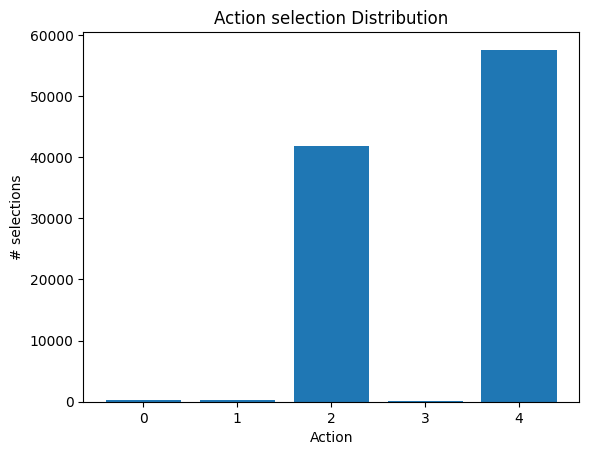

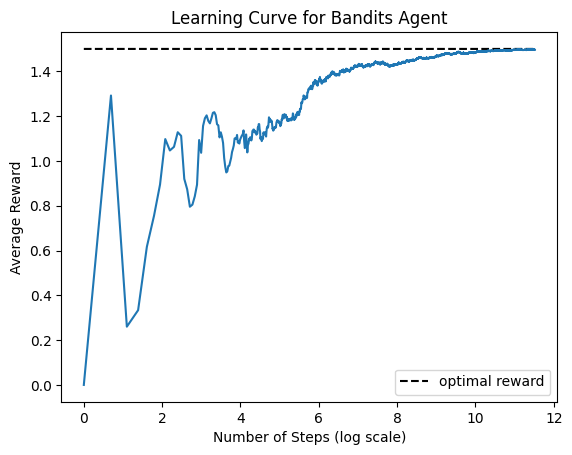

In [10]:
bandit.plot_Bandits_learning()

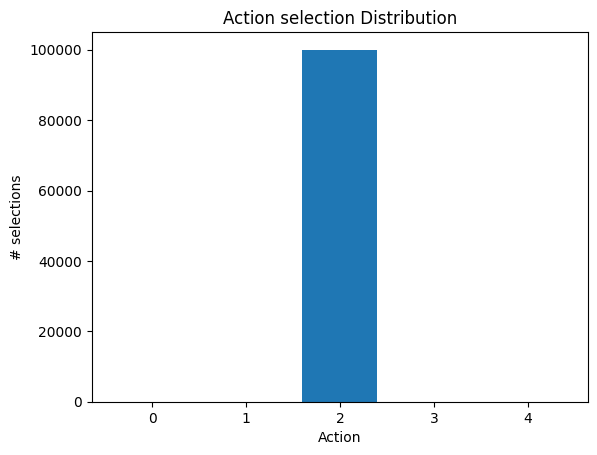

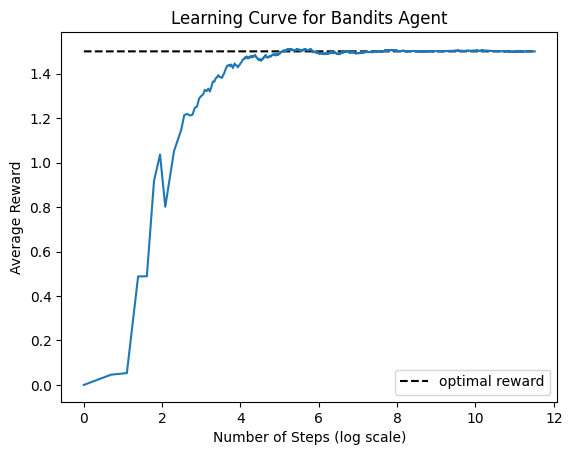

In [11]:
bandits_obj = Bandits()
bandits_obj.learn(ep_greedy = False)
bandits_obj.plot_Bandits_learning()

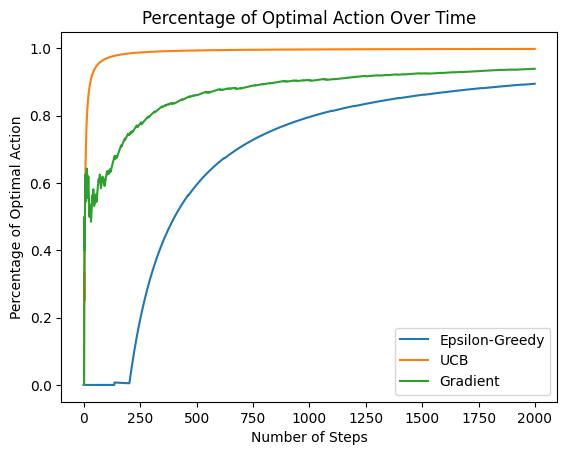

In [12]:
bandit1 = Bandits()
bandit2 = Bandits()
bandit3 = Bandits()

N5 = bandit1.learn(ep_greedy=False)
N5_epgr = bandit2.learn(ep_greedy=True)
N5_grad = bandit3.learn_gradient()


# plots the average reward at every step
plt.figure()
plt.plot(np.arange(2000), N5_epgr[:2000], label='Epsilon-Greedy')
plt.plot(np.arange(2000), N5[:2000], label='UCB')
plt.plot(np.arange(2000), N5_grad[:2000], label='Gradient')
        # plt.plot(np.arange(len(self.avg_reward)), self.get_optimal_reward()*np.ones(len(self.avg_reward)), color='k', linestyle='--', label='optimal reward')
        # plt.plot(np.arange(len(self.avg_reward)), self.avg_reward)
plt.xlabel('Number of Steps')
plt.ylabel('Percentage of Optimal Action')
plt.title('Percentage of Optimal Action Over Time')
plt.legend()  

# Q2: Value Iteration

In [13]:
from gym import Env
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [14]:
#this class defines a 2D coordinate system
class Coordinate(object):
  def __init__(self, x, y, is_dangerous):
    #changing x will move vertically and y will move horizontally
    self.x = x
    self.y = y
    self.danger = is_dangerous
  def __str__(self):
    return "({}, {}, {})".format(self.x, self.y, self.danger)

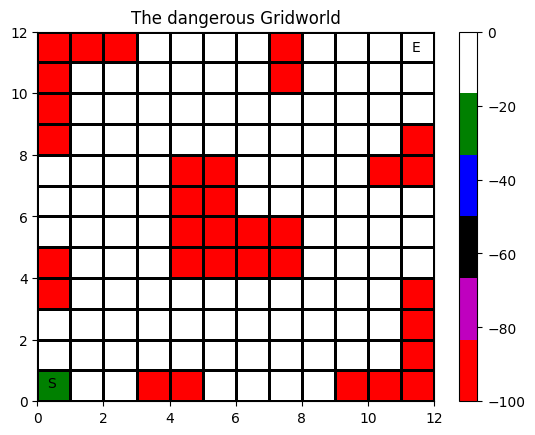

In [15]:
#We need extend the functionalities of the Env class (the superclass here is the env class)
#This is the environment class: where our agent will learn.
class dangerous_gridWorld(Env):
  #override the the following, in the Env class
  def __init__(self, grid_specs=[12,12], start_state=[0, 0], end_state=[11, 11], danger_states = [[False, False, False, True, True, False, False, False, False, True, True, True], 
                                                                                                  [False, False, False, False, False, False, False, False, False, False, False, True],
                                                                                                  [False, False, False, False, False, False, False, False, False, False, False, True],
                                                                                                  [True, False, False, False, False, False, False, False, False, False, False, True], 
                                                                                                  [True, False, False, False, True, True, True, True, False, False, False, False], 
                                                                                                  [False, False, False, False, True, True, True, True, False, False, False, False], 
                                                                                                  [False, False, False, False, True, True, False, False, False, False, False, False], 
                                                                                                  [False, False, False, False, True, True,  False, False, False, False, True, True], 
                                                                                                  [True, False, False, False, False, False, False, False, False, False, False, True],
                                                                                                  [True, False, False, False, False, False, False, False, False, False, False, False],
                                                                                                  [True, False, False, False, False, False, False, True, False, False, False, False], 
                                                                                                  [True, True, True, False, False, False, False, True, False, False, False, False]]):
  
    #initialize out setting, state space, action and rewards
    self.grid_specs = grid_specs
    #Dynamics of the MDP
    #action space
    self.actions =  ['left', 'up', 'right', 'down']
    #state space (defines the shape of the gridworld)
    #the states in itself has the knowledge of whether it is dangerous
    self.states = [[Coordinate(i, j, danger_states[i][j]) for j in range(grid_specs[1])] for i in range(grid_specs[0])]
    #for a SSPP
    self.start_state = Coordinate(start_state[0], start_state[1], False)
    self.end_state = Coordinate(end_state[0], end_state[1], False)
    
    #since the transition probabilities are deterministic 
    #(i.e.: next state and reward is determinitic and hence we don't need to define it)

  def get_D_i(self):
    D_i = np.zeros(shape=self.grid_specs, dtype=bool)
    for i in range(self.grid_specs[0]):
      for j in range(self.grid_specs[1]):
        if (self.states[i][j].danger==True):
          D_i[i][j] = True
        elif i==0 or j==0:
          if i==0 and (j<self.grid_specs[1]-1 and self.states[i][j+1].danger == True) or (j-1>0 and self.states[i][j-1].danger == True):
            D_i[i][j] = True
          elif j==0 and (i<self.grid_specs[0]-1 and self.states[i+1][j].danger == True) or (i-1>0 and self.states[i-1][j].danger == True):
            D_i[i][j] = True  
          else:
            D_i[i][j] = False
        elif i==self.grid_specs[0]-1 or j==self.grid_specs[1]-1:
          if i==self.grid_specs[0]-1 and (j<self.grid_specs[1]-1 and self.states[i][j+1].danger == True) or (j-1>0 and self.states[i][j-1].danger == True):
            D_i[i][j] = True
          elif j==self.grid_specs[1]-1 and (i<self.grid_specs[0]-1 and self.states[i+1][j].danger == True) or (i-1>0 and self.states[i-1][j].danger == True):
            D_i[i][j] = True  
          else:
            D_i[i][j] = False
        elif (self.states[i+1][j].danger == True or self.states[i-1][j].danger == True) or (self.states[i][j+1].danger == True or self.states[i][j-1].danger ==True):
          D_i[i][j] = True
    return D_i

  def step(self, state, action):
    #current state is of Coordinate type and action is a single string

    #define the dynamics of a single step
    #(0,0) is the start state and (7, 7) is the terminal state
    #Going outside the grid incurs a penalty of -5 and entering the dangerous states makes the penalty be as high as -20 (hoping teacher can save the day)
    #x axis and y axis are inverted here
    next_state = None
    #flag_out = False
    reward = -1
    if action == 'left':
      if state.y - 1 < 0:
        #going out of the grid
        next_state = self.states[state.x][state.y]
        #flag_out = True
      else:
        next_state = self.states[state.x][state.y-1]
        
    elif action == "up":
      if state.x + 1 > self.end_state.x:
        #going out of the grid
        next_state = self.states[state.x][state.y]
        #went out of the grid
      else:
        next_state = self.states[state.x+1][state.y]
          
    elif action == "right":
      if state.y + 1 > self.end_state.y:
        #going out of the grid
        next_state = self.states[state.x][state.y]
        #went out of the grid
      else:
        next_state = self.states[state.x][state.y+1]
        #if the next state is a danger state: then a reward of -20 will be encountered

    elif action == "down":
      if state.x - 1 < 0:
        #going out of the grid
        next_state = self.states[state.x][state.y]
        #flag_out = True
      else:
        next_state = self.states[state.x-1][state.y]
        #if the next state is a danger state: then a reward of -20 will be encountered
    else:
      print("Invalid Action")
      next_state = state
      reward = 0

    #if flag_out== True:
    #  reward = -20
    #if the next state is a danger state: then a reward of -20 will be encountered
    if self.states[next_state.x][next_state.y].danger == True:
      reward = -100

    done = False
    if next_state.x == self.end_state.x and next_state.y == self.end_state.y:
      done = True
    #an empty dictionary needs to be returned as prescribed by the documents. This is used for returning any extra information
    info = {}
    return next_state, reward, done, info

  def render(self, current_state, title=""):
    #render graphics for the environment
    mesh_gd = np.zeros((self.end_state.x+1, self.end_state.y+1))
    for i in range(mesh_gd.shape[0]):
      for j in range(mesh_gd.shape[1]):
        if self.states[i][j].danger == True:
          mesh_gd[i][j] = -100
        else:
          mesh_gd[i][j] = 0 
    mesh_gd[current_state.x][current_state.y] = -20
    plt.pcolormesh(mesh_gd, edgecolors='black', linewidth=2, cmap = col.ListedColormap(['r', 'm', 'k', 'b', 'g', 'w']))
    plt.colorbar()
    #adjusting text according to the relative positioning
    plt.figtext(0.71, 0.84, "E")
    plt.figtext(0.14, 0.14, "S")
    plt.title("The dangerous Gridworld"+title)
   
  def disp2(self, dang_states):
    mesh_gd = np.zeros((self.end_state.x+1, self.end_state.y+1))
    for i in range(mesh_gd.shape[0]):
      for j in range(mesh_gd.shape[1]):
        if self.states[i][j].danger == True:
          mesh_gd[i][j] = -100
        elif dang_states[i][j] == True:
          mesh_gd[i][j] = -40
        else:
          mesh_gd[i][j] = 0
    
    plt.pcolormesh(mesh_gd, edgecolors='black', linewidth=2, cmap = col.ListedColormap(['r', 'y', 'w']))
    plt.colorbar()
    #adjusting text according to the relative positioning
    plt.figtext(0.71, 0.84, "E")
    plt.figtext(0.14, 0.14, "S")
    plt.title("The teacher's knowledge of the grid world")

  def reset(self):
    #reset at the end of an episode
    return self.start_state
  
  def is_terminal(self, state):
    if state.x == self.end_state.x and state.y == self.end_state.y:
      return True
    return False

  def __str__(self):
    print("states: ")
    for i in range(self.grid_specs[0]):
      for j in range(self.grid_specs[1]):
        print(self.states[i][j])
    print('Start State: {}'.format(self.start_state))
    print('End State: {}'.format(self.end_state))
    return "actions: {}".format(self.actions)

gw = dangerous_gridWorld()
#gw.render(Coordinate(0, 0, True))
gw.render(gw.start_state)
#gw.render(gw.end_state)
#n_state, reward = gw.step(gw.states[1][2], "down")
#print(n_state, reward)

# Q2: Value Iteration

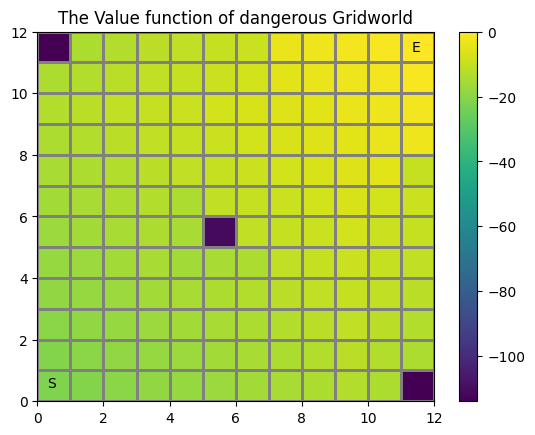

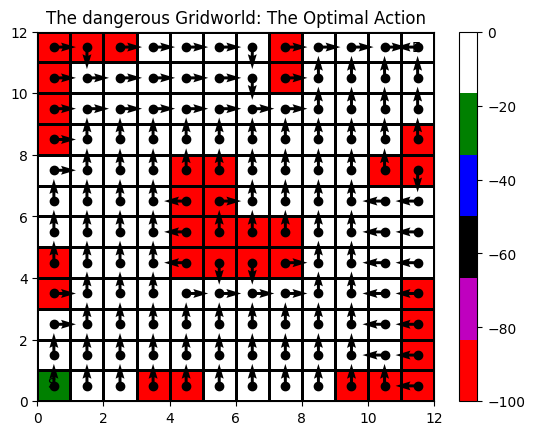

In [16]:
class value_iteration_Agent(object):
  #NOTE: env is the environment object
  def __init__(self, env):
    #for tabular methods V and pi is sufficient (Here we are trying to maximize reward)
    self.V = np.zeros((env.grid_specs[0], env.grid_specs[1]))
    self.optimal_action = np.zeros((env.grid_specs[0], env.grid_specs[1]), dtype=int)
    #generates the policy map
    #pi has 1 if you can select an action otherwise it will be 0
    self.pi_indicator = np.ones((env.grid_specs[0], env.grid_specs[1], len(env.actions))) #3D matrix
    #This will store the conditional probability p(s', r|s, a)
    #for this the P values will be equiprobable in all the next states that is optimal
    self.pi_prob = self.update_P()
    #discount factor
    self.gamma = 1
  def reset(self, env):
    self.V = np.zeros((env.grid_specs[0], env.grid_specs[1]))
    #generates the policy map
    #pi has 1 if you can select an action otherwise it will be 0
    self.pi_indicator = np.ones((env.grid_specs[0], env.grid_specs[1], len(env.actions))) #3D matrix
    #This will store the conditional probability p(s', r|s, a)
    #for this the P values will be equiprobable in all the next states that is optimal
    self.pi_prob = self.update_P()

  def reset_V(self, env):
    self.V = np.zeros((env.grid_specs[0], env.grid_specs[1]))
  def update_P(self):
    return self.pi_indicator / (np.sum(self.pi_indicator, axis=2, keepdims=True))

  def update_state_VI(self, env, this_state):
    # The value of the terminal state is always set to 0
    if env.is_terminal(this_state) == True:
      return 0
    #non terminal states

    max_value = -1*float('inf')
    for action in env.actions:
        next_state, reward, _, _ = env.step(this_state, action)
        next_value = (reward + self.gamma*self.V[next_state.x, next_state.y])
        if next_value > max_value:
            max_value = next_value
            self.optimal_action[this_state.x, this_state.y] = env.actions.index(action)

    return max_value

  def value_iteration(self,env, max_iter = 1000, epsilon = 1e-9):

    for iter in range(max_iter):
        delta = 0
        for i in range(self.V.shape[0]):
            for j in range(self.V.shape[1]):
                if env.is_terminal(env.states[i][j]):
                    break
                old_val = np.copy(self.V[i, j])
                self.V[i, j] = self.update_state_VI(env, env.states[i][j])
                delta = np.maximum(delta, np.abs(self.V[i, j] - old_val))
        if delta < epsilon:
          break



  def update_state(self, env, this_state):
    # The value of the terminal state is always set to 0
    if env.is_terminal(this_state) == True:
      return 0
    #non terminal states
    update_value = 0
    for action in env.actions:
      #actions possible are same for everyone here
      next_state, reward, _, _ = env.step(this_state, action)
      #Bellman update rule, deterministic environment and hence there is no inner loop
      update_value = update_value + self.pi_prob[this_state.x, this_state.y, env.actions.index(action)]*(reward + self.gamma*self.V[next_state.x, next_state.y])
    return update_value

  def policy_evaluation(self, env, max_iter = 1000, epsilon = 1e-9):
    #finds the value function of the current policy
    for itr in range(max_iter):
      theta = 0    
      #This is iteration over all the states
      for i in range(self.V.shape[0]):
        for j in range(self.V.shape[1]):
          if env.is_terminal(env.states[i][j]):
            break
          old_val = np.copy(self.V[i, j])
          self.V[i, j] = self.update_state(env, env.states[i][j])
          theta = np.maximum(theta, np.abs(self.V[i, j] - old_val))
      if theta < epsilon:
        break
  #return all the best actions
  def greedy_action(self, env, this_state):
    import math
    # The value of the terminal state is always set to 0
    if env.is_terminal(this_state) == True:
      pol_new = [0, 1, 2, 3] #returns the actions possible 
      return pol_new
    #non terminal states
    max_value = -1*float('inf')
    temp_actions = []
    ctr = 0
    for action in env.actions:
      #actions possible are same for everyone here
      next_state, reward, _, _ = env.step(this_state, action)
      #Bellman update rule, deterministic environment and hence there is no inner loop
      next_value = (reward + self.gamma*self.V[next_state.x, next_state.y])
      #index of maximizing action
      if math.isclose(next_value, max_value):
        temp_actions.append(ctr)
      elif next_value > max_value:
        temp_actions =  []
        temp_actions.append(ctr)
        max_value = next_value
      
      ctr = ctr + 1
      
    return temp_actions
  
  def policy_improvement(self, env):
    for i in range(self.V.shape[0]):
      for j in range(self.V.shape[1]):
        #if env.is_terminal(env.states[i][j]):
        #    break
        #Need to get the optimal action
        best_actions = self.greedy_action(env, env.states[i][j])
        #resets the pi to change the values
        for ac in range(len(env.actions)):
          self.pi_indicator[i, j, ac] = 0
        for k in best_actions:
          #all greedy actions next
          self.pi_indicator[i, j, k] = 1 

    self.pi_prob = self.update_P()

  #this is the policy iteration algorithm
  def policy_itertion(self, env):
    while True:
      old_V = np.copy(self.V)
      self.reset_V(env)
      self.policy_evaluation(env)
      #this improvement, once this ends improving, we are sure that the algorithm has converged
      self.policy_improvement(env)
      #once improvement is no longer possible
      if np.allclose(old_V, self.V):
        break

  def print_optimal_value_function(self, env):
    #env.render(env.start_state)
    plt.pcolormesh(self.V, edgecolors='grey')
    plt.figtext(0.71, 0.84, "E")
    plt.figtext(0.14, 0.14, "S")
    plt.title("The Value function of dangerous Gridworld")
    plt.colorbar()
    plt.show()
    #print(self.V)
    
  def print_optimal_policy(self, env):
    env.render(env.states[0][0], ": The Optimal Policy")
    for i in range(env.grid_specs[0]):
       for j in range(env.grid_specs[1]):
        plt.scatter(i+0.5, j+0.5, color='black')
        if env.is_terminal(env.states[i][j]):
            continue
        for k in range(len(env.actions)): 
          
          #print arrow (x, y, dx, dy) 
          #print along j first (because here we are printing from row-wise from bottom to up but pi_indicator, 
          #and quiver follow caresian convention, which is opposite of pcolormesh convention)
          if self.pi_indicator[i, j, 0]==1:
            #left
            plt.quiver(j+0.5, i+0.5, -0.4, 0, color='black')
          if self.pi_indicator[i, j, 1]==1:
            #up
            plt.quiver(j+0.5, i+0.5, 0, 0.4, color='black')
          if self.pi_indicator[i, j, 2]==1:
            #right
            plt.quiver(j+0.5, i+0.5, 0.4, 0, color='black')
          if self.pi_indicator[i, j, 3]==1:
            #down
            plt.quiver(j+0.5, i+0.5, 0, -0.4, color='black')

  def print_optimal_action(self, env):
    env.render(env.states[0][0], ": The Optimal Action")
    for i in range(env.grid_specs[0]):
       for j in range(env.grid_specs[1]):
        plt.scatter(i+0.5, j+0.5, color='black')
        for k in range(len(env.actions)): 
          #print arrow (x, y, dx, dy) 
          #print along j first (because here we are printing from row-wise from bottom to up but pi_indicator, 
          #and quiver follow caresian convention, which is opposite of pcolormesh convention)
          if self.optimal_action[i, j] == k:
            if k == 0 and self.pi_indicator[i, j, 0] == 1:
              #left
              plt.quiver(j+0.5, i+0.5, -0.4, 0, color='black')
            elif k == 1 and self.pi_indicator[i, j, 1] == 1:
              #up
              plt.quiver(j+0.5, i+0.5, 0, 0.4, color='black')
            elif k == 2 and self.pi_indicator[i, j, 2] == 1:
              #right
              plt.quiver(j+0.5, i+0.5, 0.4, 0, color='black')
            elif k == 3 and self.pi_indicator[i, j, 3] == 1:
              #down
              plt.quiver(j+0.5, i+0.5, 0, -0.4, color='black')

           
          

#testing performance of policy iteration

agent_p_iter = value_iteration_Agent(gw)  
#agent_p_iter.reset(gw) 
agent_p_iter.value_iteration(gw)
agent_p_iter.print_optimal_value_function(gw)
agent_p_iter.print_optimal_action(gw)